In [1]:
%matplotlib inline
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm 
from PIL import Image
import numpy as np
import random
import os
import shutil

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
root_dir = "COVID-19_Radiography_Dataset"
classes = ['covid','normal','pneumonia']

# create a test folder and move 300 images of each class there
if not os.path.isdir(os.path.join(root_dir,'test')):
    os.mkdir(os.path.join(root_dir,'test')) # create a test folder
    for c in classes:
        os.mkdir(os.path.join(root_dir, 'test', c)) # create the subfolders with the class names for test folder
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 300)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

In [4]:
class ChestXRayDataset(torch.utils.data.Dataset): # inherits from torch.utils.data.Dataset--> just some functions we will override
    # takes as arguments the image directories (dictionary with keys being the classes and values the directories that contain the images for that class)
    # transforms will be applied to each image (resizing & normalization)
    def __init__(self, image_dirs, transform):
        def get_images(class_name): # returns all images for a class in its image directory
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')] # get the image names in the directory image_dirs[class_name] (sanity check for png)
            print(f"Found {len(images)} {class_name} examples")
            return images 
        self.images = {} # initialize emtpy dictionary to store image file names
        self.class_names = ['covid', 'normal','pneumonia'] # define class names in dataset

        for c in self.class_names:
            self.images[c] = get_images(c) # fill images dictionary with class names as keys and the images as values
        
        self.image_dirs = image_dirs
        self.transform = transform

        # Determine the smallest class size
        self.min_class_size = min(len(images) for images in self.images.values())
        print(f"smallest class size is {self.min_class_size}")
        
        # Create a balanced dataset
        self.balanced_dataset = []
        for class_name in self.class_names:
            # Select N images from each class, where N is the size of the smallest class
            self.balanced_dataset.extend([(class_name, image) for image in self.images[class_name][:self.min_class_size]])
        random.shuffle(self.balanced_dataset)  # Shuffle once after creating the balanced list


    # returns total number of images in the dataset (across all classes)
    def __len__(self): 
        return len(self.balanced_dataset)
    
    # retrieve an image and its label by a given index, enables indexing and iteration over the dataset
    def __getitem__(self, index):
        class_name, image_name = self.balanced_dataset[index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB') 
        return self.transform(image), self.class_names.index(class_name)
    

In [5]:
# set up the image transformations 
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)), # resize image
    torchvision.transforms.RandomHorizontalFlip(), # random flip
    torchvision.transforms.ToTensor(), # convert PIL image to tensor and scale pixel vals to [0,1]
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # mean and std of Imagenet as we use model pretrained on imagenet
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # mean and std of Imagenet
])

In [6]:
train_dirs = {
    'normal' : 'COVID-19_Radiography_Dataset/normal',
    'covid' : 'COVID-19_Radiography_Dataset/covid',
    'pneumonia' : 'COVID-19_Radiography_Dataset/pneumonia',
}

test_dirs = {
    'normal' : 'COVID-19_Radiography_Dataset/test/normal',
    'covid' : 'COVID-19_Radiography_Dataset/test/covid',
    'pneumonia' : 'COVID-19_Radiography_Dataset/test/pneumonia', 
}

# define training and test datasets
train_dataset = ChestXRayDataset(train_dirs, train_transform)
test_dataset = ChestXRayDataset(test_dirs, test_transform)

# create train and test dataloaders
batch_size = 6 
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(f"number of training batches: {len(dataloader_train)}")
print(f"number of testing batches: {len(dataloader_test)}")

Found 3226 covid examples
Found 9802 normal examples
Found 955 pneumonia examples
smallest class size is 955
Found 300 covid examples
Found 300 normal examples
Found 300 pneumonia examples
smallest class size is 300
number of training batches: 478
number of testing batches: 150


In [7]:
class_names = train_dataset.class_names # get class names

# function to show some images with their labels and predictions
def show_images(images, labels, predictions):
    plt.figure(figsize=(12,6))
    for i, img in enumerate(images):
        plt.subplot(1,6,i+1)
        img = img.numpy().transpose((1,2,0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = img * std + mean # undo normalization
        img = np.clip(img, 0., 1.) 
        plt.imshow(img)
        color = 'green' if predictions[i]== labels[i] else 'red'
        plt.xlabel(f"{class_names[int(labels[i].numpy())]}")
        plt.ylabel(f"{class_names[int(predictions[i].numpy())]}",color=color)
    plt.tight_layout()
    plt.show()

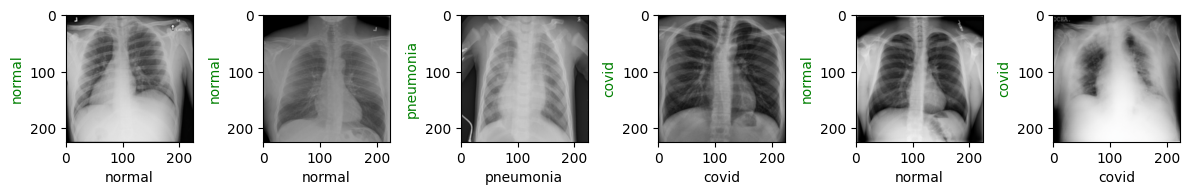

In [8]:
# just show some images
images, labels = next(iter(dataloader_train))
show_images(images,labels,labels)

In [10]:
model = torchvision.models.resnet18(weights=True) # load pretrained resnet18 - by default all layers are set to "requires_grad=True" i.e. all layers are unfrozen
# print(model)
# Freeze all layers in the model
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last few layers
for param in model.layer4.parameters():  # Unfreeze the last conv block
    param.requires_grad = True
model.fc.requires_grad = True  # Unfreeze the fc layer

# print(model) # see architecture with layers - check output layer --> here is fc
model.fc = torch.nn.Linear(in_features=512, out_features=3) # adapt last layer to output 3 classes
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001) # ensure the optimizer only updates the parameters that are unfrozen (requires_grad=True)

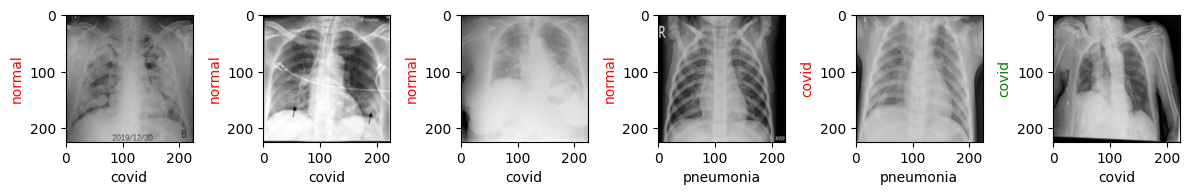

In [11]:
# show some predictions
def show_predictions():
    model.eval() # switch to evaluation mode (crucial if model behaves different in testing and train mode - i.e. models with batch normalization and dropout)
    # iter(dataloader) creates an iterator from the dataloader, and next() fetches next batch from that iterator --> so this retrieves a single batch from the test dataloader
    images, labels = next(iter(dataloader_test)) 
    outputs = model(images) # model makes predictions on the images from test dataloader
    _, predictions = torch.max(outputs, 1) # get maximum scores (softmax) and index of those --> these are the predicted labels
    show_images(images, labels, predictions) # show images with labels and predictions
show_predictions()

In [12]:
def train(epochs):
    model.to(device) # move model to device
    print("Starting training")
    for epoch in range(epochs):
        print(f"Starting epoch {epoch+1}")
        train_loss = 0
        model.train()
        # batch processing
        train_dataloader = tqdm(dataloader_train, desc=f"Epoch {epoch+1}")
        for train_step, (images,labels) in enumerate(train_dataloader): # iterate over training dataset, loaded in batches
            images, labels = images.to(device), labels.to(device)  # Move data to the device
            optimizer.zero_grad() # clear old gradients bc gradients accumulate by default
            outputs = model(images) # forward pass - make predictions
            loss = loss_fn(outputs, labels) # compute loss from predictions and true labels
            loss.backward() # backward pass (backpropagation)
            optimizer.step() # update model params based on gradients
            train_loss += loss.item() # accumulate training loss for reporting
            if train_step % 20 == 0: # every 20 steps --> evaluate on test dataset
                print(f"Evaluation at step {train_step}")
                acc = 0
                val_loss = 0
                model.eval()
                val_dataloader = tqdm(dataloader_test, desc="Validation", leave=False)
                for val_step, (images, labels) in enumerate(val_dataloader):
                    images, labels = images.to(device), labels.to(device)  # Move data to the device
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    _, predictions = torch.max(outputs, 1)
                    acc += sum((predictions==labels).numpy())
                val_loss /= (val_step +1)
                acc = acc / len(test_dataset)
                print(f"Validation Loss is {val_loss:.4f}, Accuracy: {acc:.4f}")
                show_predictions()
                model.train()
                if acc > 0.95:
                    print("Performance condition satisfied")
                    return 
        train_loss /= (train_step +1)
        print(f"Training Loss is {train_loss}")

Starting training
Starting epoch 1


Epoch 1:   0%|          | 0/478 [00:00<?, ?it/s]

Evaluation at step 0


Validation Loss is 1.4650, Accuracy: 0.3644


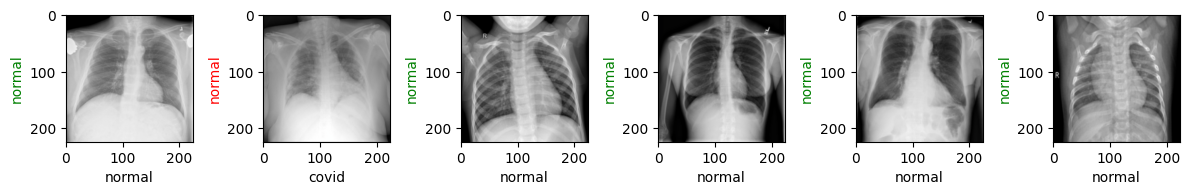

Epoch 1:   4%|▍         | 20/478 [00:52<03:34,  2.13it/s] 

Evaluation at step 20


Validation Loss is 1.7771, Accuracy: 0.7589


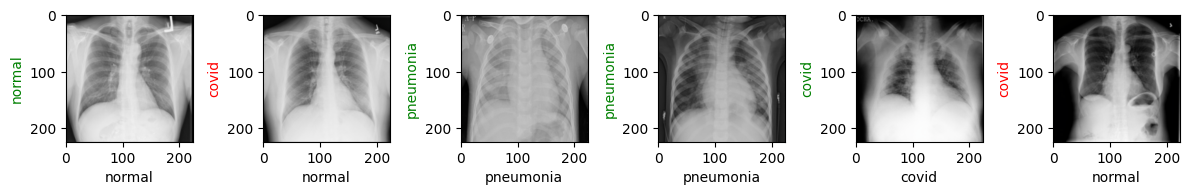

Epoch 1:   8%|▊         | 40/478 [01:40<03:15,  2.24it/s]  

Evaluation at step 40


Validation Loss is 0.8435, Accuracy: 0.7678


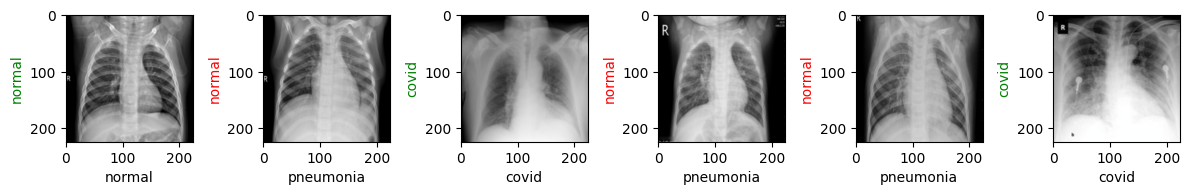

Epoch 1:  13%|█▎        | 60/478 [02:26<03:05,  2.25it/s]  

Evaluation at step 60


Validation Loss is 0.4548, Accuracy: 0.8567


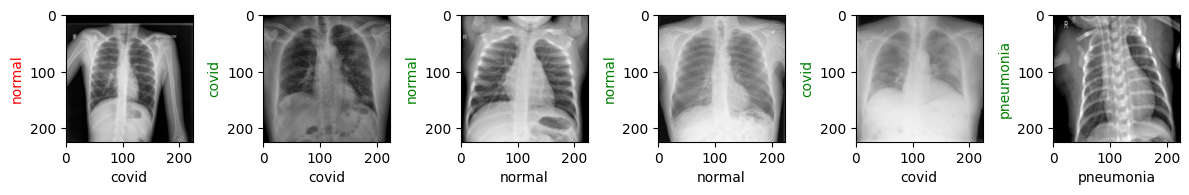

Epoch 1:  17%|█▋        | 80/478 [03:13<02:53,  2.30it/s]  

Evaluation at step 80


Validation Loss is 0.3606, Accuracy: 0.8667


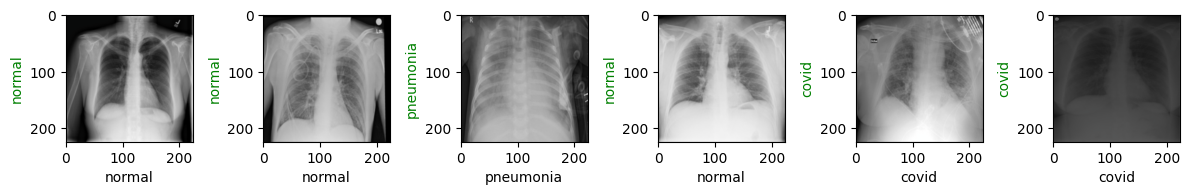

Epoch 1:  21%|██        | 100/478 [04:00<02:50,  2.21it/s] 

Evaluation at step 100


Validation Loss is 0.3234, Accuracy: 0.8833


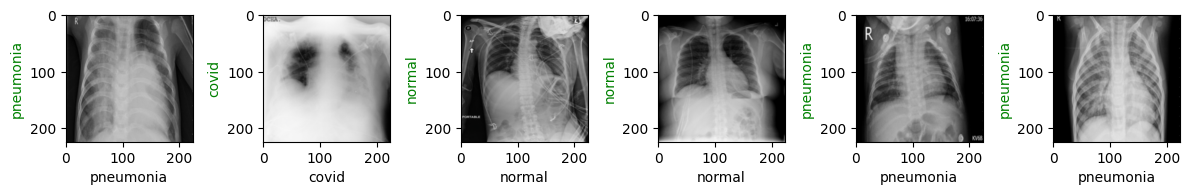

Epoch 1:  25%|██▌       | 120/478 [04:46<02:37,  2.28it/s]  

Evaluation at step 120


Validation Loss is 0.3714, Accuracy: 0.8611


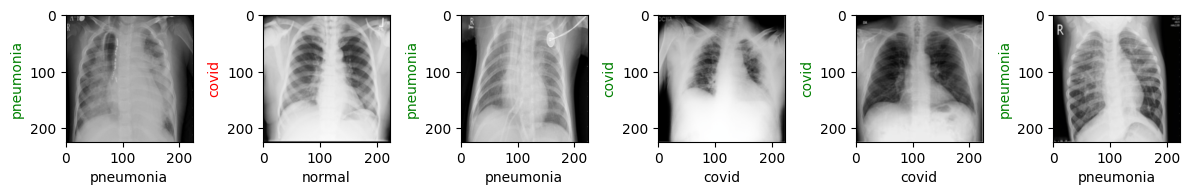

Epoch 1:  29%|██▉       | 140/478 [05:31<02:24,  2.34it/s]  

Evaluation at step 140


Validation Loss is 0.2858, Accuracy: 0.8911


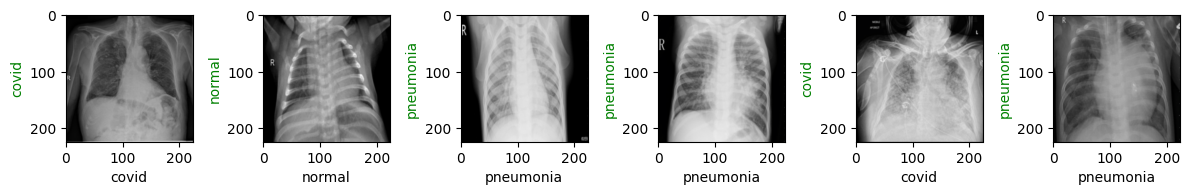

Epoch 1:  33%|███▎      | 160/478 [06:18<02:20,  2.26it/s]  

Evaluation at step 160


Validation Loss is 0.3232, Accuracy: 0.8800


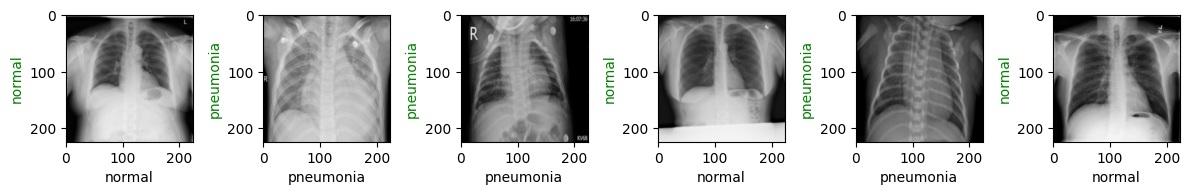

Epoch 1:  38%|███▊      | 180/478 [07:04<02:25,  2.05it/s]  

Evaluation at step 180


Validation Loss is 0.3119, Accuracy: 0.8867


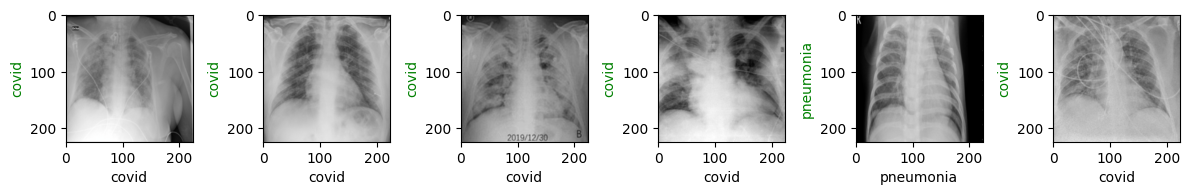

Epoch 1:  42%|████▏     | 200/478 [07:51<01:58,  2.34it/s]

Evaluation at step 200


Validation Loss is 0.2584, Accuracy: 0.9022


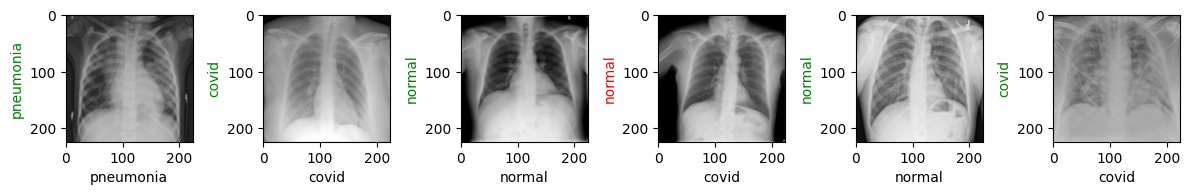

Epoch 1:  46%|████▌     | 220/478 [08:36<01:51,  2.30it/s]

Evaluation at step 220


Validation Loss is 0.2718, Accuracy: 0.8822


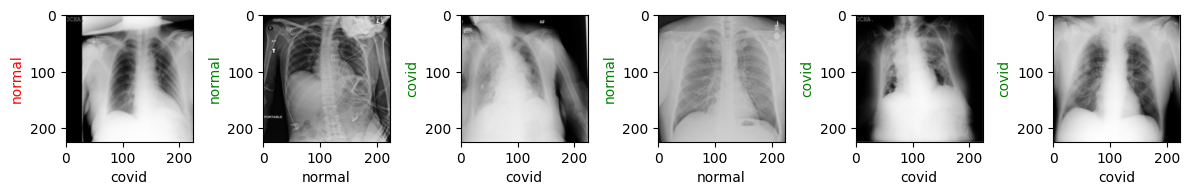

Epoch 1:  50%|█████     | 240/478 [09:23<01:43,  2.29it/s]

Evaluation at step 240


Validation Loss is 0.2858, Accuracy: 0.8822


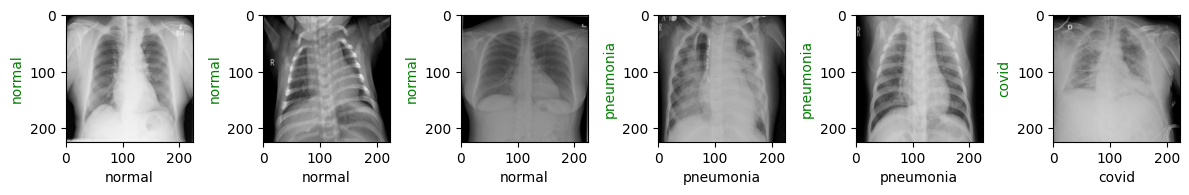

Epoch 1:  54%|█████▍    | 260/478 [10:08<01:35,  2.28it/s]

Evaluation at step 260


Validation Loss is 0.2738, Accuracy: 0.8933


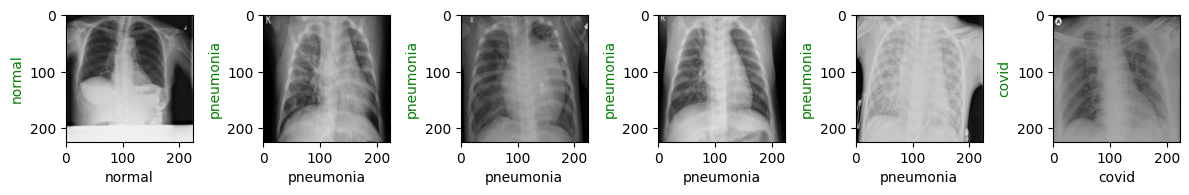

Epoch 1:  59%|█████▊    | 280/478 [11:25<02:25,  1.36it/s]  

Evaluation at step 280


Validation Loss is 0.5308, Accuracy: 0.7767


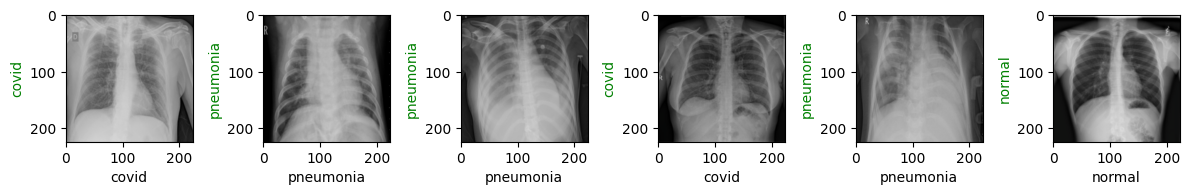

Epoch 1:  63%|██████▎   | 300/478 [12:25<01:27,  2.03it/s]

Evaluation at step 300


Validation Loss is 0.2125, Accuracy: 0.9211


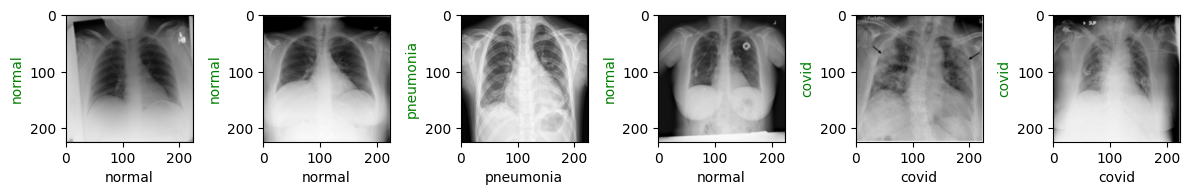

Epoch 1:  67%|██████▋   | 320/478 [13:44<01:54,  1.38it/s]

Evaluation at step 320


Validation Loss is 0.2906, Accuracy: 0.8844


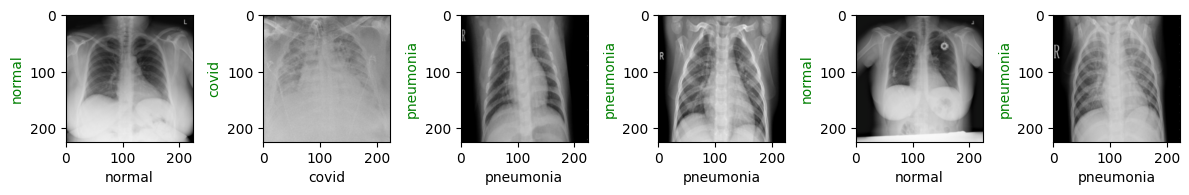

Epoch 1:  71%|███████   | 340/478 [15:04<01:41,  1.36it/s]

Evaluation at step 340


Validation Loss is 0.3219, Accuracy: 0.8456


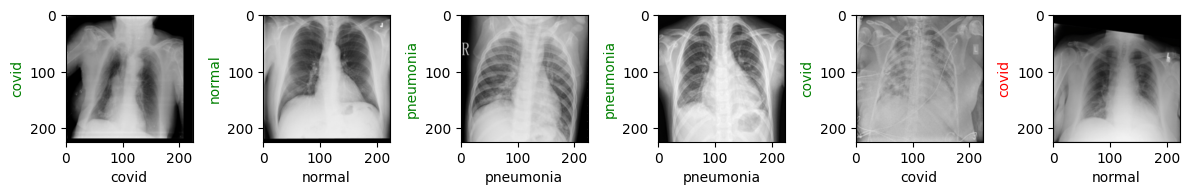

Epoch 1:  75%|███████▌  | 360/478 [16:24<01:25,  1.37it/s]

Evaluation at step 360


Validation Loss is 0.2547, Accuracy: 0.9144


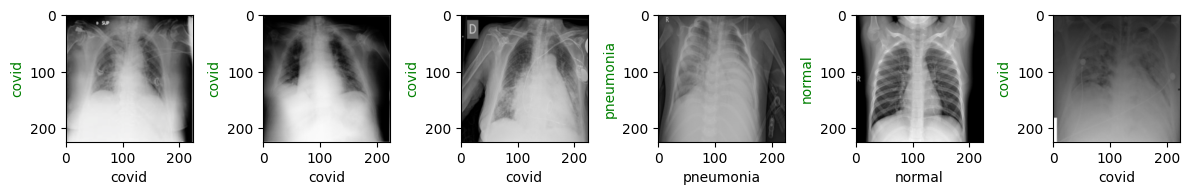

Epoch 1:  79%|███████▉  | 380/478 [17:42<01:06,  1.47it/s]

Evaluation at step 380


Validation Loss is 0.2437, Accuracy: 0.9100


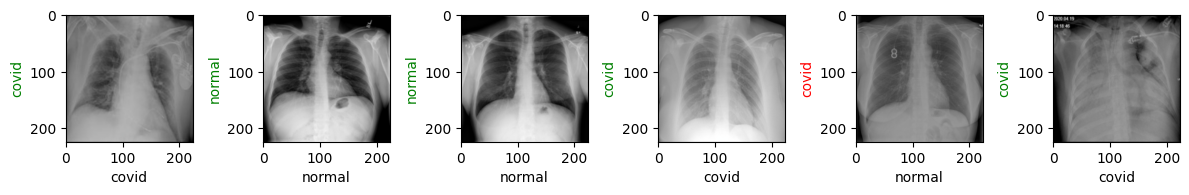

Epoch 1:  84%|████████▎ | 400/478 [19:01<00:56,  1.38it/s]

Evaluation at step 400


Validation Loss is 0.4919, Accuracy: 0.8600


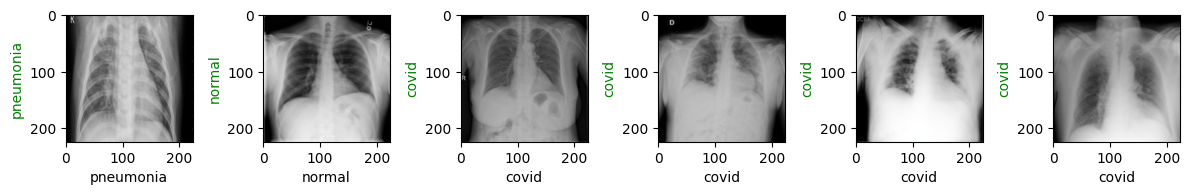

Epoch 1:  88%|████████▊ | 420/478 [20:13<00:44,  1.31it/s]

Evaluation at step 420


Validation Loss is 0.2598, Accuracy: 0.8900


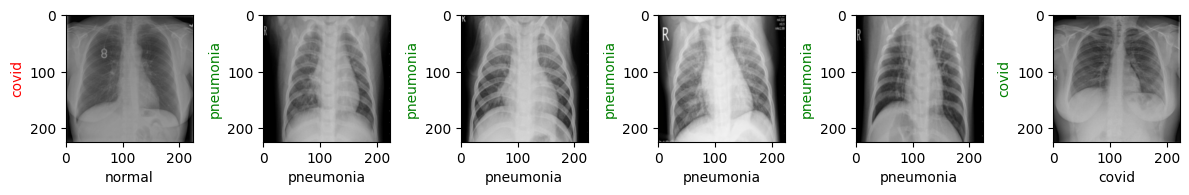

Epoch 1:  92%|█████████▏| 440/478 [21:31<00:27,  1.39it/s]

Evaluation at step 440


Validation Loss is 0.2659, Accuracy: 0.9033


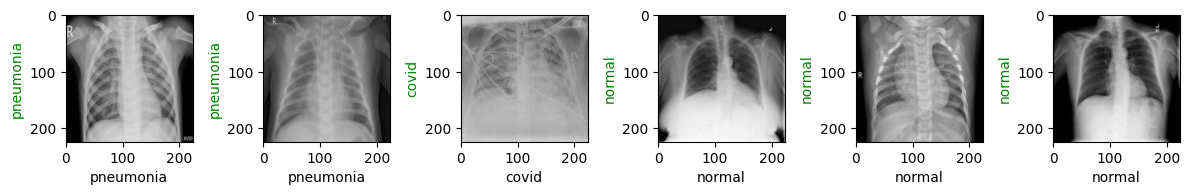

Epoch 1:  96%|█████████▌| 460/478 [22:46<00:08,  2.08it/s]

Evaluation at step 460


Validation Loss is 0.2287, Accuracy: 0.9189


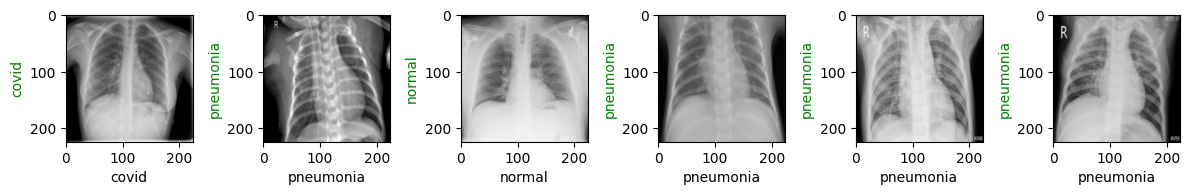

Epoch 1: 100%|██████████| 478/478 [23:45<00:00,  2.98s/it]

Training Loss is 0.44238659710658396


In [13]:
# train the model for one epoch (...)
train(epochs=1)